**CLASIFICACION ONE VS ALL**

 El conjunto de datos consiste en imágenes de dígitos escritos a mano del 0 al 9. Cada imagen tiene un tamaño de 28x28 píxeles y está representada como una matriz de 784 píxeles, donde cada píxel tiene un valor de intensidad en escala de grises entre 0 y 255.

https://www.kaggle.com/datasets/oddrationale/mnist-in-csv?select=mnist_train.csv

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

import pandas as pd

In [3]:
data = np.loadtxt("/content/drive/MyDrive/Codigos de Aby/mnist_train.csv", delimiter=',',skiprows=1)

#La primera columna(0) son las etiquetas (y) y las demas(apartir de la columana 1) son las (x)
X, y = data[:, 1:], data[:, 0]
print(X.shape)
print(y.shape)

(60000, 784)
(60000,)


In [4]:
#print(data)

In [5]:
data.shape

(60000, 785)

In [6]:
#ESTO ES PARA QUE ME DEVUELVA CUANTAS COLUMNAS SON
#data.shape
X.shape[1]

784

In [7]:
y[y == 10] = 0

In [8]:
input_layer_size =784 #28X28
#NUMERO DE ETIQUETAS
num_labels = 10
m = y.size

In [9]:
#Visualizacion de datos
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

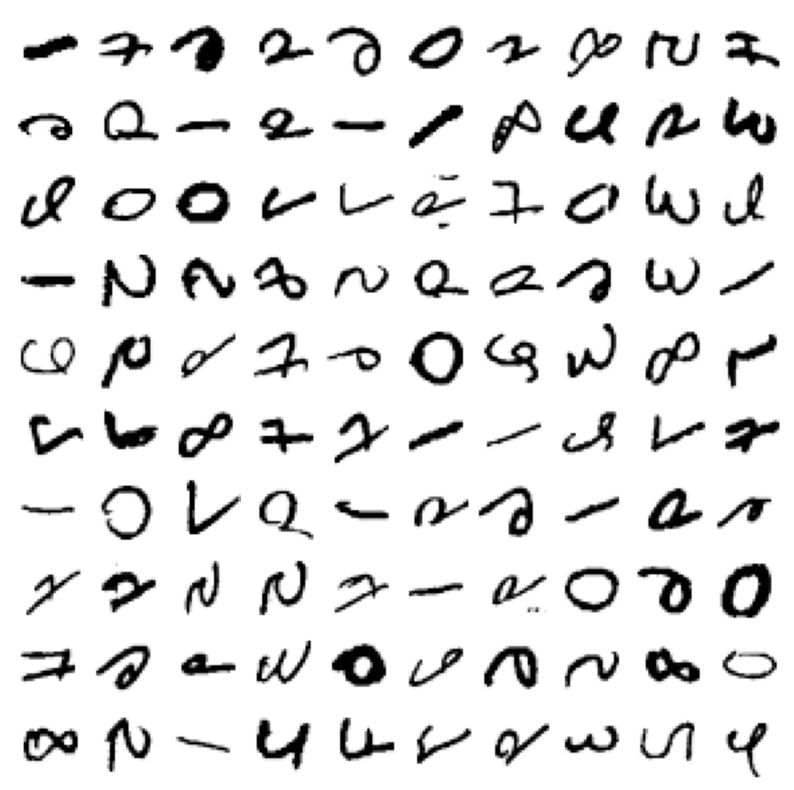

In [10]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [11]:
#Vectorización de regresión logistica

# valores de prueba para los parámetros theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# valores de prueba para las entradas
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# valores de testeo para las etiquetas
y_t = np.array([1, 0, 1, 0, 1])

# valores de testeo para el parametro de regularizacion
lambda_t = 3

In [12]:
#Vectorización de la función de costo

def sigmoid(z):
    #Aplicar la función sigmoide con clipping para evitar desbordamiento
    clippend_z = np.clip(z, -700, 700) #Limitar los valores para evitar Overflow (desbordamiento)
    return 1.0 / (1.0 + np.exp(-clippend_z))


In [13]:
def lrCostFunction(theta, X, y, lambda_):

    #Calcula el costo de usar theta como parámetro para la regresión logística regularizada y el gradiente del costo w.r.t. a los parámetros.
    # Inicializa algunos valores utiles
    m = y.size

    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    temp = theta
    temp[0] = 0

    #epsilon para evitar log(0)
    epsilon = 1e-15

#     J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)
#     theta = theta - (alpha / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    return J, grad
#    return J, theta

In [14]:
#Clasificación One-vs-all

def oneVsAll(X, y, num_labels, lambda_):

    # algunas variables utiles
    m, n = X.shape

    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)

        all_theta[c] = res.x

    return all_theta

In [29]:
lambda_ = 0.000001 #Se modifica a eleccion
all_theta = oneVsAll(X, y, num_labels, lambda_)
print(all_theta.shape)

<ipython-input-13-d076ec40120d>:23: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))


(10, 785)


In [30]:
#Predicción One-vs-all

def predictOneVsAll(all_theta, X):
    """
    Devuelve un vector de predicciones para cada ejemplo en la matriz X.
    Tenga en cuenta que X contiene los ejemplos en filas.
    all_theta es una matriz donde la i-ésima fila es un vector theta de regresión logística entrenada para la i-ésima clase.
    Debe establecer p en un vector de valores de 0..K-1 (por ejemplo, p = [0, 2, 0, 1]
    predice clases 0, 2, 0, 1 para 4 ejemplos).


    """

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

(60000, 784)
Precision del conjunto de entrenamiento: 92.01%
Predicciones: [0 5 0 1 5 3 4 0 1 7 6 4]
Etiquetas verdaderas: [0. 5. 0. 1. 3. 3. 4. 0. 1. 7. 6. 4.]


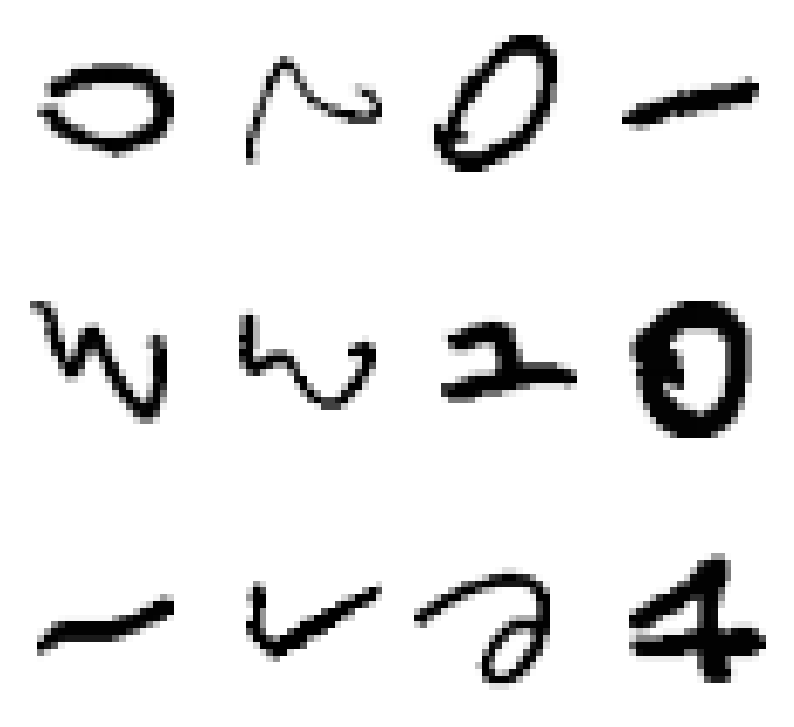

In [31]:
print(X.shape)
pred = predictOneVsAll(all_theta, X)
precision_entrenamiento = np.mean(pred == y) * 100
print('Precision del conjunto de entrenamiento: {:.2f}%'.format(precision_entrenamiento))

# Selecciona aleatoriamente 12 puntos de datos para mostrar
rand_indices = np.random.choice(m, 12, replace=False)
XPrueba = X[rand_indices, :]
XPruebaV = XPrueba.copy()


# Asegurarse de que `X` tenga el término de sesgo agregado
XPrueba = np.concatenate([np.ones((12, 1)), XPrueba], axis=1)
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis=1)
print('Predicciones:', p)
print('Etiquetas verdaderas:', y[rand_indices])

# Mostrar ejemplos de datos de prueba
displayData(XPruebaV)


In [42]:
# Cargar los datos de entrenamiento
data_train = np.loadtxt("/content/drive/MyDrive/Codigos de Aby/mnist_train.csv", delimiter=',', skiprows=1)
X_train, y_train = data_train[:, 1:], data_train[:, 0]


<ipython-input-13-d076ec40120d>:23: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))


Precisión en el conjunto de prueba: 95.25%
Predicciones: [4 2 7 4 0 2 0 2 4 9 2 0]
Etiquetas verdaderas: [4. 2. 7. 9. 0. 2. 0. 2. 4. 9. 2. 0.]


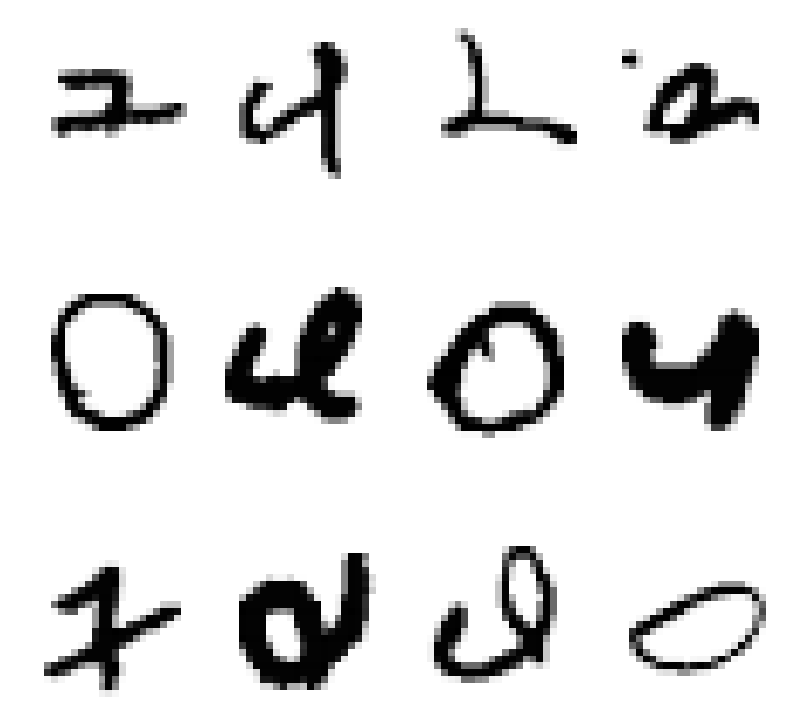

In [43]:
# Evaluar el modelo en el conjunto de prueba
data_test = np.loadtxt("/content/drive/MyDrive/Codigos de Aby/mnist_test.csv", delimiter=',', skiprows=1)
X_test, y_test = data_test[:, 1:], data_test[:, 0]
pred_test = predictOneVsAll(all_theta, X_test)
precision_test = np.mean(pred_test == y_test) * 100
print('Precisión en el conjunto de prueba: {:.2f}%'.format(precision_test))

# Seleccionar aleatoriamente 12 puntos de datos para mostrar del conjunto de prueba
rand_indices = np.random.choice(X_test.shape[0], 12, replace=False)
X_prueba = X_test[rand_indices, :]
X_prueba_v = X_prueba.copy()

# Asegurarse de que `X_prueba` tenga el término de sesgo agregado
X_prueba = np.concatenate([np.ones((12, 1)), X_prueba], axis=1)
p = np.argmax(sigmoid(X_prueba.dot(all_theta.T)), axis=1)
print('Predicciones:', p)
print('Etiquetas verdaderas:', y_test[rand_indices])

# Mostrar ejemplos de datos de prueba
displayData(X_prueba_v)
